In [1]:
import os
from PIL import Image, ImageOps
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
tf.random.set_seed(42)

# 3 Second Dataset

In [4]:
from sklearn.model_selection import train_test_split
np.random.seed(42)

directory = "mel_spectrograms_3sec/"

genres = ['blues', 'classical', 'country', 'disco', 'pop', 'hiphop', 'metal', 'reggae', 'rock', 'jazz']

X = []
Y = []

for index, g in enumerate(genres):
    filenames = os.listdir(os.path.join(directory,g))

    for f in filenames:
        img = Image.open(directory + g + '/' + f)
        img = ImageOps.crop(img, (0,1,0,0)) # 334 x 216, originally 334, 217
        img = ImageOps.grayscale(img)
        data = np.array(img)
        img.close()
        X.append(data.flatten())
        Y.append(index)

X = np.array(X)
X=X.reshape(X.shape[0],334,216)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

X_train_val,X_test,Y_train_val,Y_test=train_test_split(X,Y,test_size=0.2,train_size=0.8)

X_train,X_val,Y_train,Y_val=train_test_split(X_train_val,Y_train_val,test_size=0.25)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_val.shape, Y_val.shape) 

(10000, 334, 216)
(10000,)
(6000, 334, 216) (6000,)
(2000, 334, 216) (2000,)
(2000, 334, 216) (2000,)


In [5]:
from tensorflow import keras
num_classes = 10

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_val = keras.utils.to_categorical(Y_val, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [21]:
def create_CNN():
    model = Sequential()
    
    model.add(Conv2D(5, kernel_size=(2,2), input_shape=((334, 216,1)), activation='relu')) # ouput 64, kernel 2x2, input image shape
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.BatchNormalization(axis=1, input_shape=(5,)))
    
    model.add(Conv2D(5, kernel_size=(2,2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.BatchNormalization(axis=1, input_shape=(5,)))
    
    model.add(Flatten()) #2D -> 1D
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    print("created CNN")
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    print("compiled CNN")
    
    return model

In [22]:
CNN = create_CNN()
CNN.summary()

created CNN
compiled CNN
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 333, 215, 5)       25        
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 166, 107, 5)      0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Batc  (None, 166, 107, 5)      664       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 165, 106, 5)       105       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 82, 53, 5)        0         
 g2D)                                                            
                             

In [29]:
# ran multiple times, Keras remembers CNN model and continues epochs on the previous runs
CNN.fit(X_train, Y_train, epochs=5, batch_size=100, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/5
60/60 [==============================] - 87s 1s/step - loss: 0.3074 - accuracy: 0.9065 - val_loss: 2.5541 - val_accuracy: 0.4615
Epoch 2/5
60/60 [==============================] - 87s 1s/step - loss: 0.2688 - accuracy: 0.9198 - val_loss: 2.7725 - val_accuracy: 0.4505
Epoch 3/5
60/60 [==============================] - 100s 2s/step - loss: 0.2258 - accuracy: 0.9338 - val_loss: 2.8588 - val_accuracy: 0.4720
Epoch 4/5
60/60 [==============================] - 102s 2s/step - loss: 0.2069 - accuracy: 0.9410 - val_loss: 2.7732 - val_accuracy: 0.4810
Epoch 5/5
60/60 [==============================] - 107s 2s/step - loss: 0.1915 - accuracy: 0.9435 - val_loss: 2.9168 - val_accuracy: 0.4610


In [30]:
score = CNN.evaluate(X_test, Y_test, verbose=1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

63/63 [==============================] - 14s 217ms/step - loss: 2.9791 - accuracy: 0.4785

Test loss: 2.9790797233581543
Test accuracy: 0.47850000858306885


In [80]:
predictions = CNN.predict(X_test)
class_preds = np.argmax(predictions, axis=1)
class_preds

array([6, 3, 1, ..., 7, 1, 9])

In [81]:
import pandas as pd
classes = pd.DataFrame(class_preds, columns = ["Predicted Class"])
Y_data = pd.DataFrame(np.argmax(Y_test,axis=1), columns = ["True Class"])

In [82]:
genre_dict = dict(zip(np.linspace(0,9,10, dtype='int'),genres))
genre_dict

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'pop',
 5: 'hiphop',
 6: 'metal',
 7: 'reggae',
 8: 'rock',
 9: 'jazz'}

In [83]:
classes['Predicted Class'] = classes['Predicted Class'].map(genre_dict)
classes.head()

,Predicted Class
0,metal
1,disco
2,classical
3,disco
4,rock


In [84]:
Y_data['True Class'] = Y_data['True Class'].map(genre_dict)
Y_data.head()

,True Class
0,metal
1,pop
2,classical
3,pop
4,pop


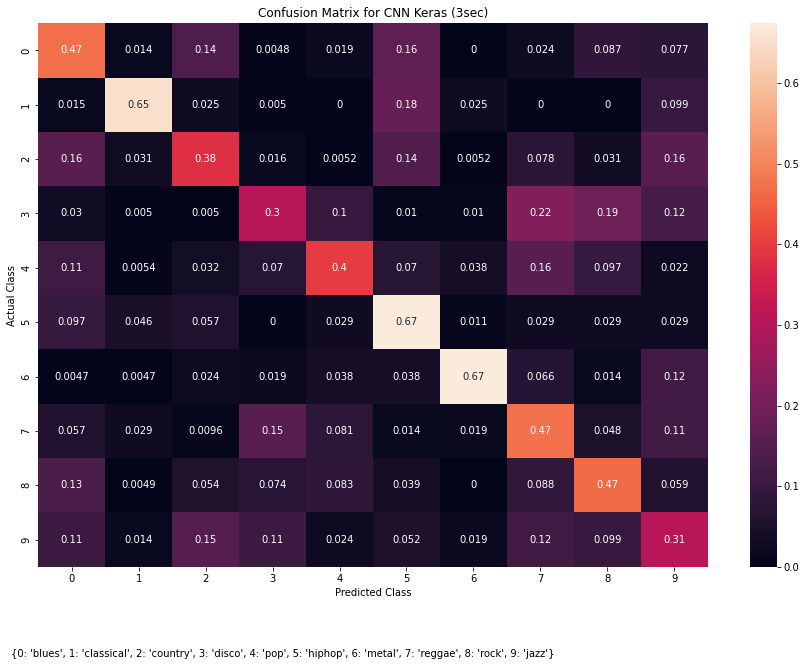

In [102]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

matrix = confusion_matrix(Y_data['True Class'], classes['Predicted Class'], normalize='true')

fig = plt.figure(figsize=(15,10))
sns.heatmap(matrix, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix for CNN Keras (3sec)')
plt.figtext(0.1, 0, genre_dict);
fig.savefig('CNN-3sec-Keras-Confusion.png')

genres = ['blues', 'classical', 'country', 'disco', 'pop', 'hiphop', 'metal', 'reggae', 'rock', 'jazz']

# 10 Second Dataset

In [103]:
np.random.seed(42)

directory = "mel_spectrograms_10sec/" # from 3 -> 10 secs

genres = ['blues', 'classical', 'country', 'disco', 'pop', 'hiphop', 'metal', 'reggae', 'rock', 'jazz']

X = []
Y = []

for index, g in enumerate(genres):
    filenames = os.listdir(os.path.join(directory,g))

    for f in filenames:
        img = Image.open(directory + g + '/' + f)
        img = ImageOps.crop(img, (0,1,0,0)) # 334 x 216, originally 334, 217
        img = ImageOps.grayscale(img)
        data = np.array(img)
        img.close()
        X.append(data.flatten())
        Y.append(index)

X = np.array(X)
X=X.reshape(X.shape[0],334,216)
Y = np.array(Y)

X_train_val,X_test,Y_train_val,Y_test=train_test_split(X,Y,test_size=0.2,train_size=0.8)

X_train,X_val,Y_train,Y_val=train_test_split(X_train_val,Y_train_val,test_size=0.25)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_val.shape, Y_val.shape) 

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_val = keras.utils.to_categorical(Y_val, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

(6000, 334, 216) (6000,)
(2000, 334, 216) (2000,)
(2000, 334, 216) (2000,)


In [119]:
def create_CNN10():
    model = Sequential()
    
    model.add(Conv2D(8, kernel_size=(2,2), input_shape=((334, 216,1)), activation='relu')) # ouput 64, kernel 2x2, input image shape
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.BatchNormalization(axis=1, input_shape=(5,)))
    
    model.add(Conv2D(8, kernel_size=(2,2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.BatchNormalization(axis=1, input_shape=(5,)))
    
    model.add(Flatten()) #2D -> 1D
    model.add(Dense(num_classes, activation='softmax'))
    print("created CNN for 10sec dataset")
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    print("compiled CNN")
    
    return model

In [120]:
CNN10 = create_CNN10()
CNN10.summary()

created CNN for 10sec dataset
compiled CNN
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 333, 215, 8)       40        
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 166, 107, 8)      0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 166, 107, 8)      664       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 165, 106, 8)       264       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 82, 53, 8)        0         
 g2D)                                                            
           

In [121]:
CNN10.fit(X_train, Y_train, epochs=10, batch_size=100, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/10
60/60 [==============================] - 98s 2s/step - loss: 14.8742 - accuracy: 0.1005 - val_loss: 18.3257 - val_accuracy: 0.1150
Epoch 2/10
60/60 [==============================] - 97s 2s/step - loss: 3.1364 - accuracy: 0.1215 - val_loss: 2.7225 - val_accuracy: 0.1175
Epoch 3/10
60/60 [==============================] - 101s 2s/step - loss: 2.8879 - accuracy: 0.1305 - val_loss: 3.0366 - val_accuracy: 0.1335
Epoch 4/10
60/60 [==============================] - 97s 2s/step - loss: 4.4769 - accuracy: 0.1337 - val_loss: 5.9590 - val_accuracy: 0.0975
Epoch 5/10
60/60 [==============================] - 101s 2s/step - loss: 4.9052 - accuracy: 0.1292 - val_loss: 3.9452 - val_accuracy: 0.1300
Epoch 6/10
60/60 [==============================] - 104s 2s/step - loss: 2.7797 - accuracy: 0.1552 - val_loss: 3.0873 - val_accuracy: 0.1655
Epoch 7/10
60/60 [==============================] - 100s 2s/step - loss: 2.7336 - accuracy: 0.1763 - val_loss: 2.7524 - val_accuracy: 0.1850
Epoch 8/10
60/

In [123]:
score = CNN10.evaluate(X_test, Y_test, verbose=1)
print()
print('Test loss (10sec):', score[0])
print('Test accuracy (10sec):', score[1])

63/63 [==============================] - 11s 169ms/step - loss: 3.6814 - accuracy: 0.1420

Test loss (10sec): 3.6814327239990234
Test accuracy (10sec): 0.1420000046491623


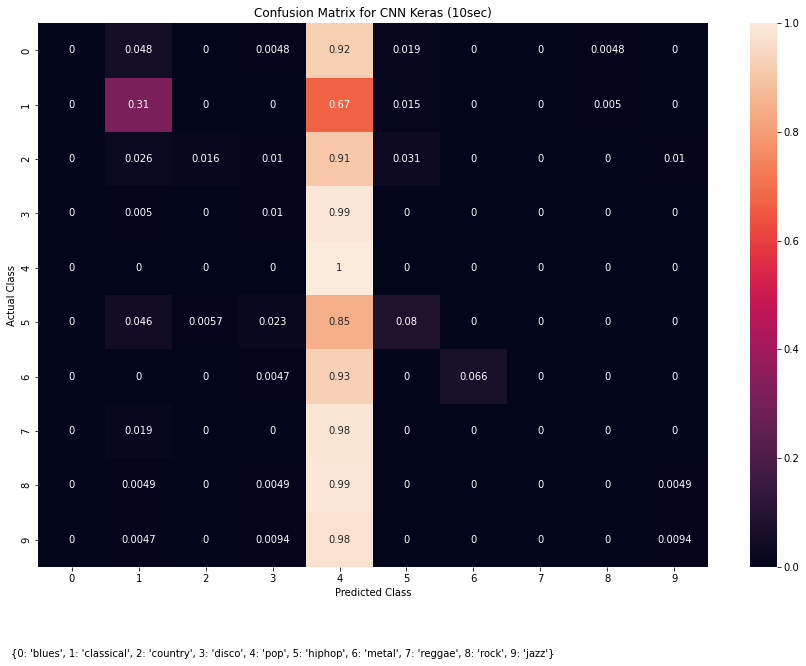

In [124]:
predictions10 = CNN10.predict(X_test)
class_preds10 = np.argmax(predictions10, axis=1)

classes10 = pd.DataFrame(class_preds10, columns = ["Predicted Class"])
Y_data = pd.DataFrame(np.argmax(Y_test,axis=1), columns = ["True Class"])

classes10['Predicted Class'] = classes10['Predicted Class'].map(genre_dict)
Y_data['True Class'] = Y_data['True Class'].map(genre_dict)

# Create Confusion matrix
matrix = confusion_matrix(Y_data['True Class'], classes10['Predicted Class'], normalize='true')

fig = plt.figure(figsize=(15,10))
sns.heatmap(matrix, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix for CNN Keras (10sec)')
plt.figtext(0.1, 0, genre_dict);
fig.savefig('CNN-10sec-Keras-Confusion.png')